#Intitialization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil.parser import parse as dateparse
import time
from collections import Counter
from tqdm.notebook import tqdm
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from datetime import datetime
from dateutil.parser import parse as dateparse
import pickle
import csv
import ast

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from sklearn.preprocessing import MultiLabelBinarizer, QuantileTransformer, OneHotEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,classification_report, make_scorer, balanced_accuracy_score, coverage_error, roc_auc_score, confusion_matrix, plot_confusion_matrix, multilabel_confusion_matrix, mean_squared_error
from sklearn.linear_model import LogisticRegression

from sklearn.utils import class_weight
import sklearn as sk

In [ ]:
from google.colab import drive, files
# drive.mount('/content/drive')

FILELOC = "/content/drive/My Drive/COVID_Python/"

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    tpu_env=True
except ValueError:
    print('Not connected to a TPU runtime.')
    tpu_env=False

Running on TPU  ['10.109.238.26:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.109.238.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.109.238.26:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#Model definition

In [ ]:
def reset_model(no_sequence_model=False, no_vars_model=False):

    model_fn = AttModel
    model = model_fn(L=ismlen,
                     numvars=NVARS,
                     vocab_size=len(aa_list)+1,
                     embdim = ENCDIM,
                     numheads = NHEADS,
                     ffdim = FFDIM,
                     num_dense = NDENSE,
                     mask_zero=True,
                     dropout_rate = DROPRATE,
                     trans_drop = TRANSDROPRATE,
                     Nt = NT,
                     W = 1, Nc = NC, Nl = NL,
                     )
    if no_sequence_model:
        model_fn = DenseModel
        model = model_fn(numvars=NVARS,
                         num_dense=NDENSE,
                         dropout_rate=DROPRATE)
    elif no_vars_model:
        model_fn = AttModel_NoVars
        model = model_fn(L=ismlen,
                        vocab_size=len(aa_list)+1,
                        embdim = ENCDIM,
                        numheads = NHEADS,
                        ffdim = FFDIM,
                        num_dense = NDENSE,
                        mask_zero=True,
                        dropout_rate = DROPRATE,
                        trans_drop = TRANSDROPRATE,
                        Nt = NT,
                        W = 1, Nc = NC, Nl = NL,
                        )        

    optimizer = keras.optimizers.Adam(learning_rate=LEARN_RATE)
    loss = keras.losses.BinaryCrossentropy()
    metrics = [keras.metrics.BinaryAccuracy(name='acc')]

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics,)
    
    return model

In [ ]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [keras.layers.Dense(ff_dim, activation="relu"), keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, mask_zero=False):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size,
                                                output_dim=embed_dim,
                                                mask_zero=mask_zero)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim,
                                              mask_zero=mask_zero)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def AttModel(L, numvars, vocab_size, embdim, numheads, ffdim, num_dense=False,
             mask_zero=False, dropout_rate=False, trans_drop=0.1,
             Nt=1, W=False, Nc=False, Nl=False):

    inpSeq = keras.Input(shape=(L,))
    inpVars = keras.Input(shape=(3,))
    x = inpSeq
    v = inpVars

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    # Attention layer
    h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
    attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
    attention = keras.layers.Flatten()(attention)  
    attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
    attention = keras.layers.RepeatVector(Nc)(attention)
    attention = keras.layers.Permute([2, 1])(attention)
    representation = keras.layers.multiply([h, attention])
    representation = tf.math.reduce_sum(representation, axis = 1)
    x = representation

    h = keras.layers.concatenate([x, v])
    x = keras.layers.Dense(num_dense, activation = 'relu')(h)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    finalOut = keras.layers.Dense(1, activation='sigmoid')(x)       

    # define the model's start and end points    
    model = keras.Model([inpSeq,inpVars],finalOut)

    return model

In [ ]:
def DenseModel(numvars, num_dense, dropout_rate=False):

    inpVars = keras.Input(shape=(3,))
    v = inpVars

    x = keras.layers.Dense(num_dense, activation = 'relu')(v)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    finalOut = keras.layers.Dense(1, activation='sigmoid')(x)       

    # define the model's start and end points    
    model = keras.Model(inpVars,finalOut)

    return model

In [ ]:
def AttModel_NoVars(L, vocab_size, embdim, numheads, ffdim, num_dense=False,
                    mask_zero=False, dropout_rate=False, trans_drop=0.1,
                    Nt=1, W=False, Nc=False, Nl=False):

    inpSeq = keras.Input(shape=(L,))
    x = inpSeq

    if mask_zero:
        x = keras.layers.Masking(mask_value=0)(x)   

    x = TokenAndPositionEmbedding(L, vocab_size, embdim, mask_zero)(x)

    if W and Nc and Nl:
        for n in range(Nl):
            x = keras.layers.Conv1D(filters = Nc,
                                kernel_size = W,
                                activation = 'relu',
                                padding = 'same',
                                )(x)
            if n > 1 and n < Nl-1:
                x = keras.layers.BatchNormalization()(x)

    for n in range(Nt):
        x = TransformerBlock(Nc, numheads, ffdim, rate=trans_drop)(x)

    # Attention layer
    h = keras.layers.TimeDistributed(keras.layers.Dense(Nc, activation='tanh'))(x)
    attention = keras.layers.TimeDistributed(keras.layers.Dense(1, activation='tanh'))(h)
    attention = keras.layers.Flatten()(attention)  
    attention = keras.layers.Softmax(axis=1, name='attention')(attention) # normalize attention values
    attention = keras.layers.RepeatVector(Nc)(attention)
    attention = keras.layers.Permute([2, 1])(attention)
    representation = keras.layers.multiply([h, attention])
    representation = tf.math.reduce_sum(representation, axis = 1)
    x = representation

    x = keras.layers.Dense(num_dense, activation = 'relu')(x)
    if dropout_rate:
        x = keras.layers.Dropout(Params[dropout_rate])(x)

    finalOut = keras.layers.Dense(1, activation='sigmoid')(x)       

    # define the model's start and end points    
    model = keras.Model(inpSeq,finalOut)

    return model

In [ ]:
ismlen = 1273

def tokenize_sequences(data_dataframe, SeqCol='ISM', seqlen=1273):
    def f(x):
        if len(x) < seqlen:
            return x + '*'*(seqlen-len(x))
        elif len(x) > seqlen:
            return x[:seqlen]
        else:
            return x
    data = np.vstack(data_dataframe[SeqCol].apply(f).apply(lambda x: np.array(list(x))))
    aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
            'G', 'H', 'I', 'L', 'K', 'M', 'F',
            'P', 'S', 'T', 'W', 'Y', 'V', '-',
            ]
    aa_tokenizer = {aa_list[k]:k+1 for k in range(len(aa_list))}
    aa_tokenizer['*'] = 0
    aa_tokenizer['X'] = 0
    # optionally handle B, J, Z ambiguities
    # Asx	B	Aspartic acid or Asparagine (D or N)
    # Glx	Z	Glutamic acid or Glutamine (E or Q)
    # Xaa	X	Any amino acid
    # Xle	J	Leucine or Isoleucine (L or I)
    aa_tokenizer['B'] = 0
    aa_tokenizer['Z'] = 0
    aa_tokenizer['J'] = 0

    return np.vectorize(aa_tokenizer.get)(data)

aa_list = ['A', 'R', 'N', 'D', 'C', 'Q', 'E',
        'G', 'H', 'I', 'L', 'K', 'M', 'F',
        'P', 'S', 'T', 'W', 'Y', 'V', '-',
        ]

In [ ]:
# These parameters are currently hard-coded
ENCDIM = 1500
NC = 300
NL = 1
NT = 1
NHEADS = 8
FFDIM = 64
NDENSE = 64

TRANSDROPRATE = 0.4
DROPRATE = 0

LEARN_RATE = 0.0001

BATCH_SIZE = 48*8

STEPS_PER_EXECUTION = 50

#Data Pre-processing

In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
valdata = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_valid1001_aligned.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')

In [ ]:
mdf = mdf[((mdf.Host == 'Human')|(mdf.Host.isna()))&(mdf.Label != -1)].copy()

REFDATE = '2019-12-01'; refdt = dateparse(REFDATE)
def f(x):
    return (dateparse(x) - refdt).days
mdf['date'] = mdf['Collection date'].apply(f)

def f(x):
    if x.lower() == 'male':
        return 0
    elif x.lower() == 'female':
        return 1
    else:
        return -1
mdf['gender'] = mdf['Gender_Raw'].apply(f)

def f(x):
    if x > 99:
        return 99
    else:
        return x
mdf['age'] = mdf['Age'].apply(f)

In [ ]:
trainmdf = mdf[mdf.ISM.isin(data.ISM)]
valmdf = mdf[mdf.ISM.isin(valdata.ISM)]
print(len(trainmdf), len(trainmdf[(trainmdf.age!=-1)&(trainmdf.gender!=-1)]))
print(len(valmdf), len(valmdf[(valmdf.age!=-1)&(valmdf.gender!=-1)]))
trainmdf = trainmdf[(trainmdf.age!=-1)&(trainmdf.gender!=-1)]
valmdf = valmdf[(valmdf.age!=-1)&(valmdf.gender!=-1)]

47587 44003
23517 21913


In [ ]:
# if EXPERIMENTAL:
#     trainmdf.drop(trainmdf[trainmdf['Collection date'].apply(len) <= 4].index, inplace=True)
#     valmdf.drop(valmdf[valmdf['Collection date'].apply(len) <= 4].index, inplace=True)
#     print(len(trainmdf),len(valmdf))

In [ ]:
ytrain = trainmdf.Label.values; yval = valmdf.Label.values
seqtrain = tokenize_sequences(trainmdf, 'ISM', ismlen)
seqval = tokenize_sequences(valmdf, 'ISM', ismlen)
vartrain = trainmdf[['age','date','gender']].values
varval = valmdf[['age','date','gender']].values
xtrain = [seqtrain,vartrain]
xval = [seqval,varval]

NVARS = 3   # age, gender, date = 3 variables

In [ ]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight(class_weight='balanced',
                                                       classes=np.unique(ytrain), y=ytrain))
sample_weights = np.array([class_weights[int(y)] for y in ytrain])
print(class_weights)

[1.1281663419136498, 0.8979837557650708]


#Evaluate model to predict disease severity

In [ ]:
tf.keras.backend.clear_session()
with tpu_strategy.scope():
    model = reset_model()
    model.load_weights(f'{FILELOC}covidout_trans_fulldata_weights/covid_regresstrans_20211212.h5')

In [ ]:
omicron = pd.read_csv(FILELOC + "omicron_spike_20211209.csv")
# omicron = pd.read_csv(FILELOC + "omicron_spike_20211209_highcov.csv")
# omicron = pd.read_csv(FILELOC + "B1640_spike_20220107.csv")
# omicron = pd.read_csv(FILELOC + "omicron_spike_BA2_20220127.csv")
omicron['seqlen'] = omicron.Align.apply(len)
print(len(omicron))
omicron.drop(omicron[omicron.seqlen<1273].index, inplace=True)
omicron.reset_index(inplace=True, drop=True)
print(len(omicron))
omicron_raw = omicron.copy()
omicron = omicron.groupby(['Align']).size().to_frame().reset_index(drop=False)
print(len(omicron))


otok = tokenize_sequences(omicron,'Align',ismlen)
# otok = tokenize_sequences(omicron_raw,'Align',ismlen)


20
20
2


In [ ]:
age = 50; date = 300; gender = 0
vars = [age,date,gender]*np.ones((len(otok),3))
omicron['pred'] = model.predict([otok, vars], verbose=True)

Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


1/1 [==============================] - 4s 4s/step


In [ ]:
maxpred = np.argwhere(omicron.pred.values==max(omicron.pred))[0][0]
minpred = np.argwhere(omicron.pred.values==min(omicron.pred))[0][0]
print(minpred,maxpred)

1 29


In [ ]:
a = omicron.iloc[maxpred].Align
b = omicron.iloc[minpred].Align
print(np.where(np.array(list(a) != np.array(list(b)))))

(array([ 68,  69, 140, 141, 143, 144]),)


In [ ]:
with tpu_strategy.scope():
    get_attention_model = keras.Model(inputs=model.input,outputs=model.get_layer('attention').output)
    get_attention_model.compile()
    att = get_attention_model.predict([otok, vars], verbose=True)
omicron['att'] = [a for a in att]

1/1 [==============================] - 6s 6s/step


In [ ]:
1500/50

30.0

In [ ]:
np.arange(0,1300,50)

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


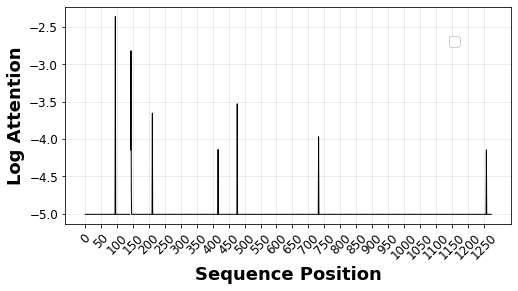

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(8,4)

ax.plot(range(1,1274), np.log10(att[maxpred]-att[minpred]), linewidth=1, color='black')

ax.set_xlabel('Sequence Position', fontsize=18, fontweight='bold')
ax.set_ylabel('Log Attention', fontsize=18, fontweight='bold')
a = np.arange(0,1350,50)
plt.xticks(a[:-1], rotation=45, fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale("log")
# ax.set_xticks(a)
# ax.set_xticklabels([str(aa) for aa in a], rotation=45, fontsize=10)
ax.grid(axis='y', which='major', alpha=0.3)
ax.grid(axis='x', which ='both', alpha=0.3)
plt.show()

In [ ]:
np.where(np.array(list(omicron.iloc[minpred].Align)) != np.array(list(omicron.iloc[maxpred].Align)))

(array([ 68,  69, 140, 141, 143, 144]),)

In [ ]:
for ind in range(len(omicron)):
    print(ind, omicron.iloc[ind].pred,
          np.where(np.array(list(omicron.iloc[minpred].Align)) != np.array(list(omicron.iloc[ind].Align))))

0 0.42727992 (array([  4, 140, 141, 143, 144]),)
1 0.3350014 (array([], dtype=int64),)
2 0.3367828 (array([210, 211]),)
3 0.40741944 (array([140, 141, 143, 144, 155, 156, 157, 439, 445, 451, 476, 483, 492,
       495, 497, 500, 504]),)
4 0.42769307 (array([140, 141, 143, 144, 171]),)
5 0.42708147 (array([140, 141, 143, 144, 175]),)
6 0.39644825 (array([140, 141, 143, 144, 345, 497, 500]),)
7 0.42706034 (array([140, 141, 143, 144, 345]),)
8 0.45399788 (array([140, 141, 143, 144, 416]),)
9 0.45399636 (array([140, 141, 143, 144, 416, 700]),)
10 0.45394132 (array([140, 141, 143, 144, 416, 439, 445, 451]),)
11 0.4538765 (array([140, 141, 143, 144, 416, 439, 445, 451, 935]),)
12 0.4274452 (array([140, 141, 143, 144, 495, 497]),)
13 0.40166786 (array([140, 141, 143, 144, 795, 855, 949, 953, 968, 980]),)
14 0.42725918 (array([ 140,  141,  143,  144, 1004]),)
15 0.42780465 (array([ 140,  141,  143,  144, 1039]),)
16 0.4272717 (array([140, 141, 143, 144]),)
17 0.4272498 (array([ 140,  141,  143,

In [ ]:
np.where(np.log10(att[maxpred]-att[minpred]) > -5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


(array([  94,  142,  143,  144,  210,  416,  476,  731, 1257]),)

In [ ]:
data = pd.read_csv(FILELOC + 'covid_aligned_crossval/covid_patient_0912_aligned_sequences.csv')
mdf = pd.read_csv(FILELOC + 'covid_alldata_merged_align1001.csv')

'V'

In [ ]:
with open(f'{FILELOC}covidout_trans_fulldata_weights/covid_regresspred_20211212.pkl','rb') as f:
    trainmdf, valmdf, trainemb, valemb, trainatt, valatt, fsdf = pickle.load(f)
linmean_train = trainmdf.groupby('Lineage').mean().join(trainmdf.groupby('Lineage').size().rename('Count'))
linmean_val = valmdf.groupby('Lineage').mean().join(valmdf.groupby('Lineage').size().rename('Count'))
linmean_train['Lineage'] = linmean_train.index
linmean_val['Lineage'] = linmean_val.index
ismtrain = trainmdf.groupby('ISM').mean().join(trainmdf.groupby('ISM').size().rename('Count'))
ismval = valmdf.groupby('ISM').mean().join(valmdf.groupby('ISM').size().rename('Count'))

In [ ]:
linmean_val[linmean_val.Count>200].rename(columns={'Label':'Mean Severity',
                                                   'date':'Relative Date',
                                                   'age':'Age',
                                                   'Pred_Trans':'Transformer',
                                                   'Pred_XGB':'XGBoost'}).drop(columns=['Age','Lineage','gender']).round(2)

,Mean Severity,Relative Date,Transformer,XGBoost,Count
Lineage,,,,,
AY.12,0.19,631.36,0.28,0.19,258
AY.20,0.69,618.55,0.43,0.64,364
AY.4,0.26,631.35,0.28,0.21,817
B.1,0.73,314.45,0.65,0.79,994
B.1.1,0.70,314.36,0.65,0.73,696
B.1.1.222,0.60,421.69,0.63,0.54,229
B.1.1.519,0.68,485.36,0.63,0.69,1583
B.1.1.7,0.60,508.85,0.49,0.56,3298
B.1.160,0.67,426.67,0.52,0.64,307


In [ ]:
# lineages = ['B.1/D614G','B.1.1.7/Alpha','P.1/Gamma','B.1.617.2/Delta']
# gender = 0
# ages = [25,50,75]
# dates = np.linspace(100,700,21)
# pred = {}
# for lin in lineages:
#     print(lin, lin.split("/")[0])
#     linism = valmdf[valmdf.Lineage==lin.split("/")[0]].groupby('ISM').size()
#     linism = linism.rename('Count').to_frame().reset_index()
#     lintok = tokenize_sequences(linism.sort_values(by='Count').tail(30), 'ISM', ismlen)
#     pred[lin] = {}
#     for age in ages:
#         pred[lin][age] = {}
#         for date in dates:
#             vars = [age,date,gender]*np.ones((len(lintok),3))
#             pred[lin][age][date] = model.predict([lintok, vars], verbose=False)

In [ ]:
# with open(FILELOC + "speculative_predictions_graph.pkl", 'wb') as f:
#     pickle.dump(pred,f)

with open(FILELOC + "speculative_predictions_graph.pkl", 'rb') as f:
    pred = pickle.load(f)

In [ ]:
# gender = 0
# ages = [25,50,75]
# dates = np.linspace(100,700,21)
# pred['B.1.529/Omicron'] = {}
# for age in ages:
#     pred['B.1.529/Omicron'][age] = {}
#     for date in dates:
#         vars = [age,date,gender]*np.ones((len(otok),3))
#         pred['B.1.529/Omicron'][age][date] = model.predict([otok, vars], verbose=True, batch_size=32*8)

# with open(FILELOC + "speculative_predictions_graph_omicron.pkl", 'wb') as f:
#     pickle.dump(pred,f)

with open(FILELOC + "speculative_predictions_graph_omicron.pkl", 'rb') as f:
    pred = pickle.load(f)

In [ ]:
# # lineages = ['B.1.617.2/Delta'] # ['B.1.1.7/Alpha','B.1.617.2/Delta']
# lineages = ['B.1.351/Beta', 'B.1.617.2/Delta', 'B.1.1.7/Alpha']

# gender = 0
# ages = [50]
# dates = np.linspace(100,700,21)
# for lin in lineages:
#     print(lin, lin.split("/")[0])
#     linism = trainmdf[trainmdf.Lineage==lin.split("/")[0]].groupby('ISM').size()
#     linism = linism.rename('Count').to_frame().reset_index()
#     lintok = tokenize_sequences(linism.sort_values(by='Count').tail(30), 'ISM', ismlen)
#     pred[lin] = {}
#     for age in ages:
#         pred[lin][age] = {}
#         for date in dates:
#             vars = [age,date,gender]*np.ones((len(lintok),3))
#             pred[lin][age][date] = model.predict([lintok, vars], verbose=False)

In [ ]:
gender = 0
ages = [25,50,75]
dates = np.linspace(100,700,21)
# VARIANT_NAME = "B.1.640"
VARIANT_NAME = "BA.2"
pred[VARIANT_NAME] = {}
for age in ages:
    pred[VARIANT_NAME][age] = {}
    for date in dates:
        vars = [age,date,gender]*np.ones((len(otok),3))
        pred[VARIANT_NAME][age][date] = model.predict([otok, vars], verbose=False, batch_size=32*8)

In [ ]:
age = 50
dates = np.linspace(100,700,21)
# lineages = ['B.1.351/Beta', 'B.1.617.2/Delta', 'B.1.1.7/Alpha', 'B.1.529/Omicron']
# lineages = ['B.1.617.2/Delta', 'B.1.1.7/Alpha', 'B.1.529/Omicron']
lineages = ['B.1.617.2/Delta', 'B.1.1.7/Alpha', 'B.1.529/Omicron', VARIANT_NAME]

severity = {}
severity_mean = {}; severity_max = {}; severity_min= {}

for lin in lineages:
    severity_mean[lin] = np.array([np.mean(pred[lin][age][d]) for d in dates])
    severity_max[lin] = np.array([np.max(pred[lin][age][d]) for d in dates])
    severity_min[lin] = np.array([np.min(pred[lin][age][d]) for d in dates])

In [ ]:
print(np.mean(np.subtract(severity_mean['B.1.617.2/Delta'], severity_mean['B.1.529/Omicron'])/np.array(severity_mean['B.1.617.2/Delta'])),
      np.mean(np.subtract(severity_min['B.1.617.2/Delta'], severity_max['B.1.529/Omicron'])/np.array(severity_min['B.1.617.2/Delta'])),
      np.mean(np.subtract(severity_max['B.1.617.2/Delta'], severity_min['B.1.529/Omicron'])/np.array(severity_max['B.1.617.2/Delta'])))

print(np.mean(np.subtract(severity_mean['B.1.1.7/Alpha'], severity_mean['B.1.529/Omicron'])/np.array(severity_mean['B.1.1.7/Alpha'])),
      np.mean(np.subtract(severity_min['B.1.1.7/Alpha'], severity_max['B.1.529/Omicron'])/np.array(severity_min['B.1.1.7/Alpha'])),
      np.mean(np.subtract(severity_max['B.1.1.7/Alpha'], severity_min['B.1.529/Omicron'])/np.array(severity_max['B.1.1.7/Alpha'])))

0.4741503 0.16518871 0.7192841
0.38688904 0.12225803 0.6304965


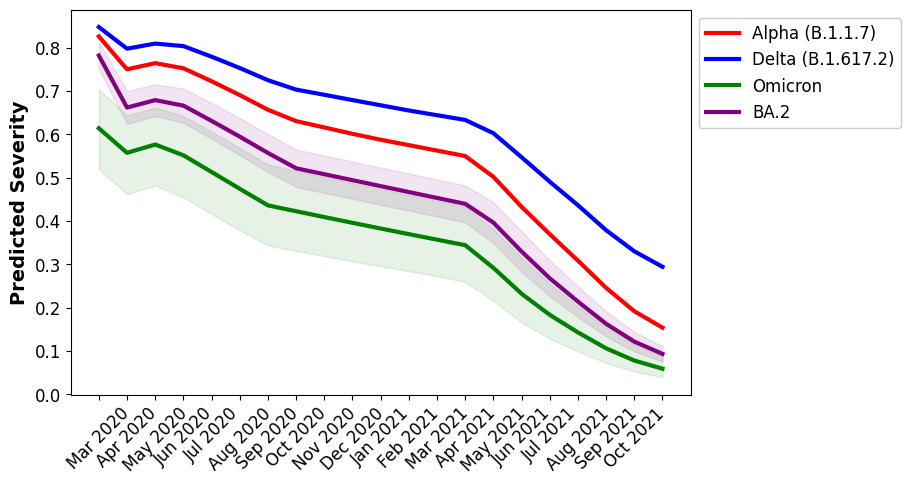

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcdefaults()
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# fig,ax = plt.subplots(2,2)
# fig.set_size_inches(8.5,8.5)

# ind2d = np.unravel_index(range(len(lineages)), (2,2))
# for l in range(len(lineages)):
#     lineage = lineages[l]
#     xi = ind2d[0][l]; yi = ind2d[1][l]
#     for age in ages:
#         linmean = [np.mean(pred[lineage][age][d]) for d in dates]
#         ax[xi][yi].plot(dates, linmean, label=f'Age: {age}')

#     ax[xi][yi].set_title(f'Projected Mean Severity ({lineage})')
#     ax[xi][yi].set_xlabel('Days since Dec. 1, 2019')

#     ax[xi][yi].legend(bbox_to_anchor=(1.0, 0.9))
# plt.show()

age = 50
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

lineage = 'B.1.1.7/Alpha'
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', linewidth=3, color = 'red', label='Alpha (B.1.1.7)')
# ax.fill_between(dates, linmin, linmax, alpha=0.1, color='red')
lineage = 'B.1.617.2/Delta'
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', color = 'blue', linewidth=3, label='Delta (B.1.617.2)')
# ax.fill_between(dates, linmean-linstd, linmean+linstd, alpha=0.3, color='blue')
# ax.fill_between(dates, linmin, linmax, alpha=0.1, color='blue')
# lineage = 'B.1.351/Beta'
# linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
# linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
# linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
# linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
# ax.plot(dates, linmean, linestyle='solid', color = 'red', linewidth=3, label='Beta (B.1.351)')
# # ax.fill_between(dates, linmin, linmax, alpha=0.1, color='green')
lineage = 'B.1.529/Omicron'
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', color = 'green', linewidth=3, label='Omicron')
ax.fill_between(dates, linmin, linmax, alpha=0.1, color='green')
lineage = VARIANT_NAME
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', color = 'purple', linewidth=3, label=VARIANT_NAME)
ax.fill_between(dates, linmin, linmax, alpha=0.1, color='purple')

ax.set_ylabel('Predicted Severity', fontsize=14, fontweight='bold')
# ax.set_xlabel('Days since Dec. 1, 2019', fontsize=14, fontweight='bold')
import datetime
datebinnames = datebinnames = [(datetime.datetime(2019,12,1) + datetime.timedelta(dates[d]+15)).strftime('%b %Y')\
                for d in range(len(dates)-1)]
ax.set_xticks(dates)
ax.set_xticklabels(datebinnames, fontsize=12, ha='center', rotation=45)
plt.yticks(fontsize=12)
ax.legend(bbox_to_anchor=(1,1), framealpha=1.0, fontsize=12)
plt.show()
plt.rcdefaults()


In [ ]:
# seq = {}
# for lin in ['B.1.351/Beta', 'B.1.617.2/Delta', 'B.1.1.7/Alpha']:
#     print(lin, lin.split("/")[0])
#     linism = trainmdf[trainmdf.Lineage==lin.split("/")[0]].groupby('ISM').size()
#     linism = linism.rename('Count').to_frame().reset_index()
#     seq[lin] = linism.sort_values(by='Count').tail(1)['ISM'].values[0]

B.1.351/Beta B.1.351
B.1.617.2/Delta B.1.617.2
B.1.1.7/Alpha B.1.1.7


In [ ]:
# np.where(np.array(list(omicron.iloc[16]['Align'])) != np.array(list(seq['B.1.1.7/Alpha'])))
# np.where(np.array(list(omicron.iloc[16]['Align'])) != np.array(list(seq['B.1.351/Beta'])))
# np.where(np.array(list(omicron.iloc[16]['Align'])) != np.array(list(seq['B.1.617.2/Delta'])))
# seq['B.1.617.2/Delta'][476]
# omicron.iloc[16]['Align'][476]

(array([  66,   94,  141,  142,  144,  210,  211,  338,  370,  372,  374,
         416,  439,  445,  476,  477,  483,  492,  495,  497,  504,  546,
         569,  654,  678,  715,  763,  795,  855,  953,  968,  980,  981,
        1117]),)

In [ ]:
# with open(f'{FILELOC}covidout_trans_fulldata_weights/covid_regresspred_20211212.pkl','rb') as f:
#     trainmdf, valmdf, trainemb, valemb, trainatt, valatt, fsdf = pickle.load(f)
# tdf = trainmdf.reset_index(drop=False)
# tdf[tdf.ISM==seq['B.1.617.2/Delta']].index
# delta = np.mean(trainatt[tdf[tdf.ISM==seq['B.1.617.2/Delta']].index],axis=0)
# beta = np.mean(trainatt[tdf[tdf.ISM==seq['B.1.351/Beta']].index], axis=0)
# alpha = np.mean(trainatt[tdf[tdf.ISM==seq['B.1.1.7/Alpha']].index], axis=0)
# for ind in omicron.index:
#     print(omicron.loc[ind]['att'][498])

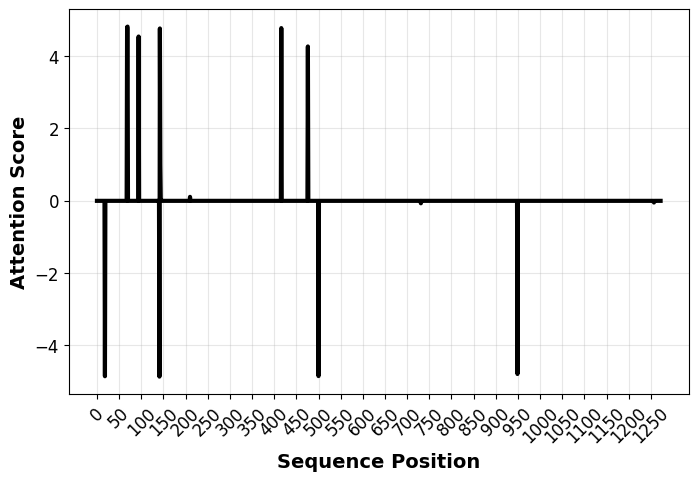

In [ ]:
# fig,ax = plt.subplots()
# fig.set_size_inches(8,5)

# # ax.plot(alpha, label='alpha')
# # ax.plot(beta,label='beta')
# # ax.plot(delta,label='delta')
# # ax.plot(omicron.iloc[16]['att'],label='omicron')

# # ax.plot(omicron.iloc[16]['att'] - alpha, label='alpha')
# # ax.plot(omicron.iloc[16]['att'] - beta,label='beta')
# # ax.plot(omicron.iloc[16]['att'] - delta,label='delta')

# ax.plot(1000*(omicron.iloc[16]['att'] - delta),color='black',linewidth=3)

# ax.set_xlabel('Sequence Position', fontsize=14, fontweight='bold')
# ax.set_ylabel('Attention Score', fontsize=14, fontweight='bold')
# a = np.arange(0,1350,50)
# plt.xticks(a[:-1], rotation=45, fontsize=12)
# plt.yticks(fontsize=12)
# # plt.yscale('symlog')
# # ax.set_xticks(a)
# # ax.set_xticklabels([str(aa) for aa in a], rotation=45, fontsize=10)
# ax.grid(axis='y', which='major', alpha=0.3)
# ax.grid(axis='x', which ='both', alpha=0.3)
# # ax.legend(bbox_to_anchor=(1.0, 1.0), framealpha=1.0, fontsize=12)
# plt.show()

In [ ]:
# np.where((omicron.iloc[16]['att'] - delta) < -0.0001)
# np.where((omicron.iloc[16]['att'] - delta) > 0.0001)

(array([ 18, 141, 500, 949]),)

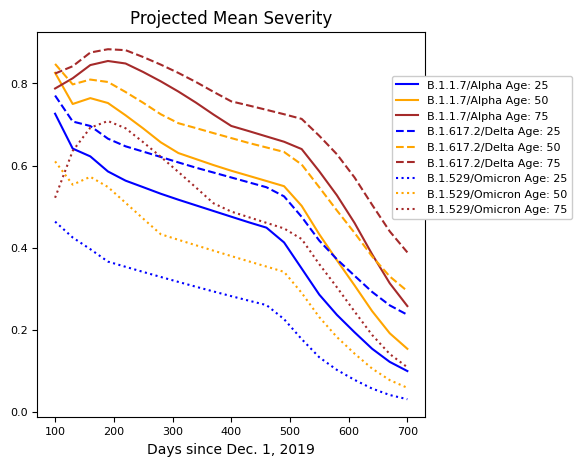

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcdefaults()
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# fig,ax = plt.subplots(2,2)
# fig.set_size_inches(8.5,8.5)

# ind2d = np.unravel_index(range(len(lineages)), (2,2))
# for l in range(len(lineages)):
#     lineage = lineages[l]
#     xi = ind2d[0][l]; yi = ind2d[1][l]
#     for age in ages:
#         linmean = [np.mean(pred[lineage][age][d]) for d in dates]
#         ax[xi][yi].plot(dates, linmean, label=f'Age: {age}')

#     ax[xi][yi].set_title(f'Projected Mean Severity ({lineage})')
#     ax[xi][yi].set_xlabel('Days since Dec. 1, 2019')

#     ax[xi][yi].legend(bbox_to_anchor=(1.0, 0.9))
# plt.show()

fig,ax = plt.subplots()
fig.set_size_inches(5,5)
lineage = 'B.1.1.7/Alpha'
colors = {25:'blue', 50:'orange', 75:'brown'}
for age in ages:
    linmean = [np.mean(pred[lineage][age][d]) for d in dates]
    ax.plot(dates, linmean, linestyle='solid', color = colors[age], label=f'{lineage} Age: {age}')
lineage = 'B.1.617.2/Delta'
for age in ages:
    linmean = [np.mean(pred[lineage][age][d]) for d in dates]
    ax.plot(dates, linmean, linestyle='dashed', color = colors[age], label=f'{lineage} Age: {age}')
lineage = 'B.1.529/Omicron'
for age in ages:
    linmean = [np.mean(pred[lineage][age][d]) for d in dates]
    ax.plot(dates, linmean, linestyle='dotted', color = colors[age], label=f'{lineage} Age: {age}')

ax.set_title(f'Projected Mean Severity')
ax.set_xlabel('Days since Dec. 1, 2019')
ax.legend(bbox_to_anchor=(0.9, 0.9), framealpha=1.0)
plt.show()

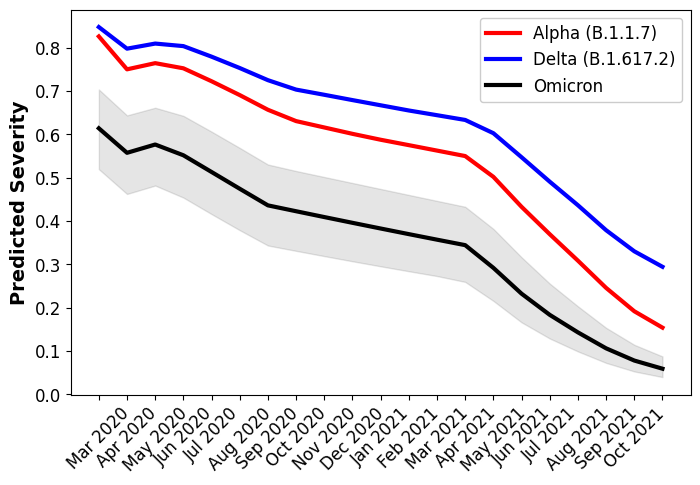

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcdefaults()
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# fig,ax = plt.subplots(2,2)
# fig.set_size_inches(8.5,8.5)

# ind2d = np.unravel_index(range(len(lineages)), (2,2))
# for l in range(len(lineages)):
#     lineage = lineages[l]
#     xi = ind2d[0][l]; yi = ind2d[1][l]
#     for age in ages:
#         linmean = [np.mean(pred[lineage][age][d]) for d in dates]
#         ax[xi][yi].plot(dates, linmean, label=f'Age: {age}')

#     ax[xi][yi].set_title(f'Projected Mean Severity ({lineage})')
#     ax[xi][yi].set_xlabel('Days since Dec. 1, 2019')

#     ax[xi][yi].legend(bbox_to_anchor=(1.0, 0.9))
# plt.show()

age = 50
fig,ax = plt.subplots()
fig.set_size_inches(8,5)

lineage = 'B.1.1.7/Alpha'
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', linewidth=3, color = 'red', label='Alpha (B.1.1.7)')
# ax.fill_between(dates, linmin, linmax, alpha=0.1, color='red')
lineage = 'B.1.617.2/Delta'
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', color = 'blue', linewidth=3, label='Delta (B.1.617.2)')
# ax.fill_between(dates, linmean-linstd, linmean+linstd, alpha=0.3, color='blue')
# ax.fill_between(dates, linmin, linmax, alpha=0.1, color='blue')
# lineage = 'B.1.351/Beta'
# linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
# linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
# linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
# linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
# ax.plot(dates, linmean, linestyle='solid', color = 'red', linewidth=3, label='Beta (B.1.351)')
# # ax.fill_between(dates, linmin, linmax, alpha=0.1, color='green')
lineage = 'B.1.529/Omicron'
linmean = np.array([np.mean(pred[lineage][age][d]) for d in dates])
linmax = np.array([np.max(pred[lineage][age][d]) for d in dates])
linmin = np.array([np.min(pred[lineage][age][d]) for d in dates])
linstd = np.array([np.std(pred[lineage][age][d]) for d in dates])
ax.plot(dates, linmean, linestyle='solid', color = 'black', linewidth=3, label='Omicron')
ax.fill_between(dates, linmin, linmax, alpha=0.1, color='black')

ax.set_ylabel('Predicted Severity', fontsize=14, fontweight='bold')
# ax.set_xlabel('Days since Dec. 1, 2019', fontsize=14, fontweight='bold')
import datetime
datebinnames = datebinnames = [(datetime.datetime(2019,12,1) + datetime.timedelta(dates[d]+15)).strftime('%b %Y')\
                for d in range(len(dates)-1)]
ax.set_xticks(dates)
ax.set_xticklabels(datebinnames, fontsize=12, ha='center', rotation=45)
plt.yticks(fontsize=12)
ax.legend(bbox_to_anchor=(1,1), framealpha=1.0, fontsize=12)
plt.show()
plt.rcdefaults()
